In [35]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import GraphHelpers as GH
import ETFunctions as et
import MathsUtilities as MUte

## Bring in the data needed

In [36]:
root = 'C:\GitHubRepos\CropWaterAnalysis'

### Met Data

In [37]:
MetData = pd.read_pickle(root+'\General\BroadfieldsMet\BroadFieldsMet.pkl')
DaylightIndex = MetData.IncomingRadnMJ.where(MetData.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()
MetData.loc[:,'satVP'] = [et.saturated_vapor_pressure(MetData.loc[x,'AirTemperature'])/10 for x in MetData.index]
MetData.loc[:,'VP'] = [MetData.loc[x,'satVP']*MetData.loc[x,'RelativeHumidity']/100 for x in MetData.index]
MetData.loc[:,'VPD'] = MetData.satVP.subtract(MetData.VP)

DailyMet = MetData.IncomingRadnMJ.resample('D').sum()
DailyMet = pd.DataFrame(index=DailyMet.index,data=DailyMet.values,columns=['Radn'])
DailyMet.loc[:,'Temp'] = MetData.AirTemperature.resample('D').mean()
DailyMet.loc[:,'RH'] = MetData.RelativeHumidity.resample('D').mean()
DailyMet.loc[:,'VPD'] = MetData.loc[DaylightIndex,'VPD'].resample('D').mean()
MinVPD = 0.1
DailyMet.loc[:,'VP'] = MetData.VP.resample('D').mean()
DailyMet.loc[:,'VPD'] = DailyMet.loc[:,'VPD'].where(DailyMet.loc[:,'VPD']>MinVPD,MinVPD)
DailyMet.loc[:,'Wind'] = MetData.Windspeed.resample('D').mean()
DailyMet.loc[:,'Rainfall'] = MetData.loc[:,'Rainfall'].resample('D').sum()
DailyMet.loc[:,'PET'] = [et.PenmanEO(DailyMet.loc[x,'Radn'],
                                    DailyMet.loc[x,'Temp'],
                                    DailyMet.loc[x,'Wind'],
                                    DailyMet.loc[x,'VP'],
                                    'Total') for x in DailyMet.index]

AccumPET = DailyMet.PET.cumsum()

### CoverData

In [38]:
#Bring in fPAR (estimated from NDVI and interpolated to daily values) for each plot
#Note using estimated fPAR from NDVI for Barley because it was only measured on 12 plots not all 24
BarleyfPAR = pd.concat([pd.read_pickle(root+'\Barley\DataFrames\DailyFPAREstInt.pkl')],axis=1,keys=['Barley'],names =['Crop'])
#BarleyfPAR.columns = BarleyfPAR.columns.swaplevel('Cultivar','Irrigation')
#Rename cultivar treatment to Nitrogen in Barley so it can be treated the same as other crops
BarleyfPAR.columns.names = ['Depth', 'Irrigation', 'Nitrogen', 'Block']
WheatfPAR = pd.concat([pd.read_pickle(root+'\Wheat\DataFrames\DailyFPARTot.pkl')],axis=1,keys=['Wheat'],names =['Crop'])
FodderBeetfPAR = pd.concat([pd.read_pickle(root+'\FodderBeet\DataFrames\DailyFPARTot.pkl')],axis=1,keys=['FodderBeet'],names =['Crop'])
LucernefPAR = pd.read_pickle(root+'\LucerneAndPasture\DataFrames\LucDailyfPAREstInt.pkl')
RyegrassfPAR = pd.read_pickle(root+'\LucerneAndPasture\DataFrames\RyeDailyfPAREstInt.pkl')
OatsfPAR = pd.concat([pd.read_pickle(root+'\Oats\DataFrames\DailyFPARTot.pkl')],axis=1,keys=['Oats'],names =['Crop'])
fPAR = pd.concat([WheatfPAR,FodderBeetfPAR,LucernefPAR,RyegrassfPAR,OatsfPAR,BarleyfPAR],axis=1)
fPAR.dropna(how='all',inplace=True)
GH.SortFrame(fPAR)

In [39]:
BarleyfPAR

Depth         Barley                                                    \
Irrigation      Dash                                                     
Nitrogen        High                                     Low             
Block              1         2         3         4         1         2   
2014-11-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2014-11-03  0.047744  0.000000  0.000000  0.000000  0.000000  0.000000   
2014-11-04  0.095487  0.000000  0.000000  0.000000  0.000000  0.000000   
2014-11-05  0.116638  0.033030  0.033030  0.043840  0.015689  0.015689   
2014-11-06  0.137789  0.066060  0.066060  0.087679  0.031379  0.031379   
2014-11-07  0.158939  0.099089  0.099089  0.131519  0.047068  0.047068   
2014-11-08  0.203634  0.136746  0.136746  0.155269  0.073042  0.078146   
2014-11-09  0.262842  0.186631  0.186631  0.186731  0.107451  0.119316   
2014-11-10  0.320959  0.235596  0.235596  0.217614  0.141225  0.159727   
2014-11-11  0.357646  0.277608  0.272056  0.273226  0.170184  0.203427   
2014-11-12  0.378929  0.301979  0.293207  0.305487  0.186982  0.228777   
2014-11-13  0.400716  0.326929  0.314859  0.338513  0.204180  0.254728   
2014-11-14  0.428149  0.357386  0.341968  0.362266  0.239163  0.288442   
2014-11-15  0.464627  0.397884  0.378016  0.393850  0.285681  0.333271   
2014-11-16  0.492828  0.429193  0.405883  0.418267  0.321643  0.367927   
2014-11-17  0.520537  0.459957  0.433265  0.442258  0.356978  0.401980   
2014-11-18  0.590641  0.547529  0.509232  0.522996  0.382858  0.432841   
2014-11-19  0.653863  0.626505  0.577741  0.595807  0.406198  0.460673   
2014-11-20  0.710496  0.697249  0.639110  0.661030  0.427105  0.485604   
2014-11-21  0.723371  0.725700  0.669992  0.701169  0.477593  0.541438   
2014-11-22  0.733393  0.747846  0.694029  0.732413  0.516892  0.584898   
2014-11-23  0.740595  0.763760  0.711303  0.754865  0.545133  0.616130   
2014-11-24  0.750393  0.785410  0.734803  0.785410  0.583552  0.658617   
2014-11-25  0.786235  0.832914  0.784942  0.848001  0.590910  0.670858   
2014-11-26  0.832319  0.893993  0.849407  0.928476  0.600369  0.686596   
2014-11-27  0.873277  0.948278  0.906701  1.000000  0.608777  0.700584   
2014-11-28  0.873277  0.958251  0.924692  1.000000  0.608777  0.700584   
2014-11-29  0.873277  0.971225  0.948095  1.000000  0.608777  0.700584   
2014-11-30  0.873277  0.981425  0.966494  1.000000  0.608777  0.700584   
2014-12-01  0.873277  0.990108  0.982157  1.000000  0.608777  0.700584   
...              ...       ...       ...       ...       ...       ...   
2015-01-27  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-01-28  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-01-29  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-01-30  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-01-31  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-01  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-02  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-03  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-04  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-05  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-06  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-07  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-08  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-09  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-10  1.000000  1.000000  1.000000  1.000000  0.794485  0.885928   
2015-02-11  0.903652  0.903652  0.903652  0.903652  0.717939  0.800571   
2015-02-12  0.782406  0.782406  0.782406  0.782406  0.621610  0.693156   
2015-02-13  0.689786  0.689786  0.689786  0.689786  0.548025  0.611101   
2015-02-14  0.613417  0.613417  0.613417  0.613417  0.487351  0.543443   
2015

### Top Soil Water

In [40]:
BarleyTopVWC = pd.concat([pd.read_pickle(root+'\Barley\DataFrames\TopVWC.pkl')],axis=1,keys=['Barley'],names = ['Crop'])
#BarleyTopVWC.columns = BarleyTopVWC.columns.swaplevel('Cultivar','Irrigation')
#Rename cultivar treatment to Nitrogen in Barley so it can be treated the same as other crops
BarleyTopVWC.columns.names = ['Crop','Depth', 'Irrigation', 'Nitrogen', 'Block']
WheatTopVWC =  pd.concat([pd.read_pickle(root+'\Wheat\DataFrames\TopVWC.pkl')],axis=1,keys=['Wheat'],names = ['Crop'])
FodderBeetTopVWC =  pd.concat([pd.read_pickle(root+'\FodderBeet\DataFrames\TopVWC.pkl')],axis=1,keys=['FodderBeet'],names = ['Crop'])
OatsTopVWC =  pd.concat([pd.read_pickle(root+'\Oats\DataFrames\TopVWC.pkl')],axis=1,keys=['Oats'],names = ['Crop'])
LucerneTopVWC = pd.read_pickle(root+'\LucerneAndPasture\DataFrames\TopVWC.pkl').Lucerne
RyegrassTopVWC = pd.read_pickle(root+'\LucerneAndPasture\DataFrames\TopVWC.pkl').Ryegrass
TopVWC = pd.concat([BarleyTopVWC.loc[BarleyTopVWC.index.hour==23].resample('D').mean(),
                    WheatTopVWC.loc[WheatTopVWC.index.hour==23].resample('D').mean(),
                    FodderBeetTopVWC.loc[FodderBeetTopVWC.index.hour==23].resample('D').mean(),
                    OatsTopVWC.loc[OatsTopVWC.index.hour==23].resample('D').mean(),
                    LucerneTopVWC,RyegrassTopVWC],axis=1)
#TopVWC.columns = TopVWC.columns.swaplevel('Crop','Depth')
TopVWC = TopVWC.reorder_levels(['Crop','Irrigation','Nitrogen','Block','Depth'],axis=1)
GH.SortFrame(TopVWC)
#TopVWC = TopVWC.loc[TopVWC.index.hour==23].resample('D').mean()

## Set graphics properties

In [41]:
Crops = TopVWC.columns.get_level_values(0).drop_duplicates().values
Crops.sort()
print('Wheat')
WheatGPs = GH.SetGraphicsPatterns(TopVWC.Wheat.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])
print('Barley')
FodderBeetGPs = GH.SetGraphicsPatterns(TopVWC.FodderBeet.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])
print('Lucerne')
LucerneGPs = GH.SetGraphicsPatterns(TopVWC.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)
print('Ryegrass')
RyegrassGPs = GH.SetGraphicsPatterns(TopVWC.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)
print('Oats')
OatsGPs = GH.SetGraphicsPatterns(TopVWC.Oats.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['purple','green','orange'])
print('Barley')
BarleyGPs = GH.SetGraphicsPatterns(TopVWC.Barley.columns,
                    ['--','-'],
                    [0.45,0.15],
                    ['^','o'],
                    ['blue','red','green'])

Wheat
Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '250', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          250   -   green  0.15   o   green
          50    -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          250  --   green  0.45   ^   white
          50   --  purple  0.45   ^   white
Barley
Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '300', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '300', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o')

In [42]:
def MakeTimeSeriesGraphs(Data,name,ymin,ymax):
    Graph = plt.figure(figsize=(18,30))
    Crops = Data.columns.get_level_values(0).drop_duplicates().values
    Crops.sort()
    pos = 1
    for C in Crops:
        GP = globals()[C+'GPs']
        ax = Graph.add_subplot(3,2,pos)
        GH.AddIndexedPlotWithSEM(Data.loc[:,C].dropna(how='all'),ax,GP,2)
        plt.ylabel(name, fontsize=36);
        plt.ylim(ymin,ymax)
        plt.tick_params(labelsize=20)
        plt.title(C, fontsize=28)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=int(np.ceil(Data.loc[:,C].dropna(how='all').index.size/30/5))))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
        GH.AddLegend(1,16,'')
        pos+=1

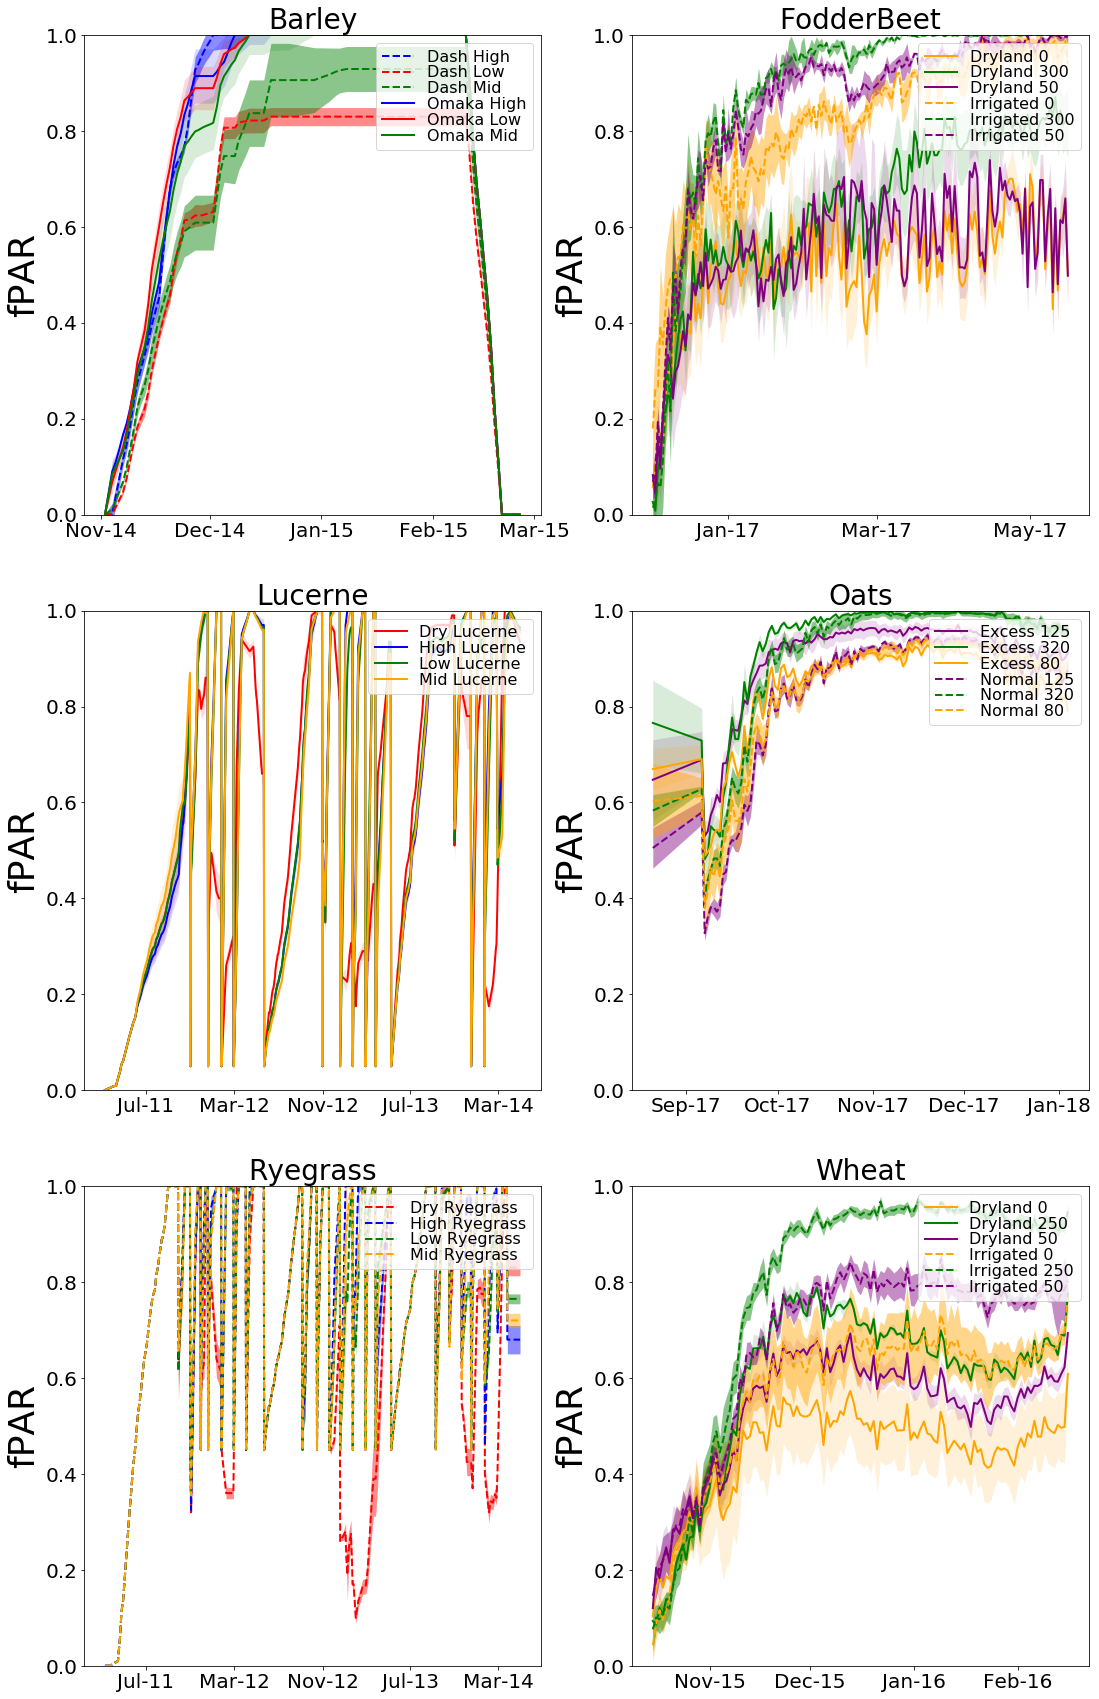

In [43]:
MakeTimeSeriesGraphs(fPAR,'fPAR',0,1)

In [44]:
Params = pd.DataFrame(index=Crops,
             data=[[0.35,0.06],[0.33,0.06],[0.3,0.08],[0.32,0.08],[0.30,0.08],[0.32,0.06]],
             columns=['FC','LL'])
Params

FC    LL
Barley      0.35  0.06
FodderBeet  0.33  0.06
Lucerne     0.30  0.08
Oats        0.32  0.08
Ryegrass    0.30  0.08
Wheat       0.32  0.06

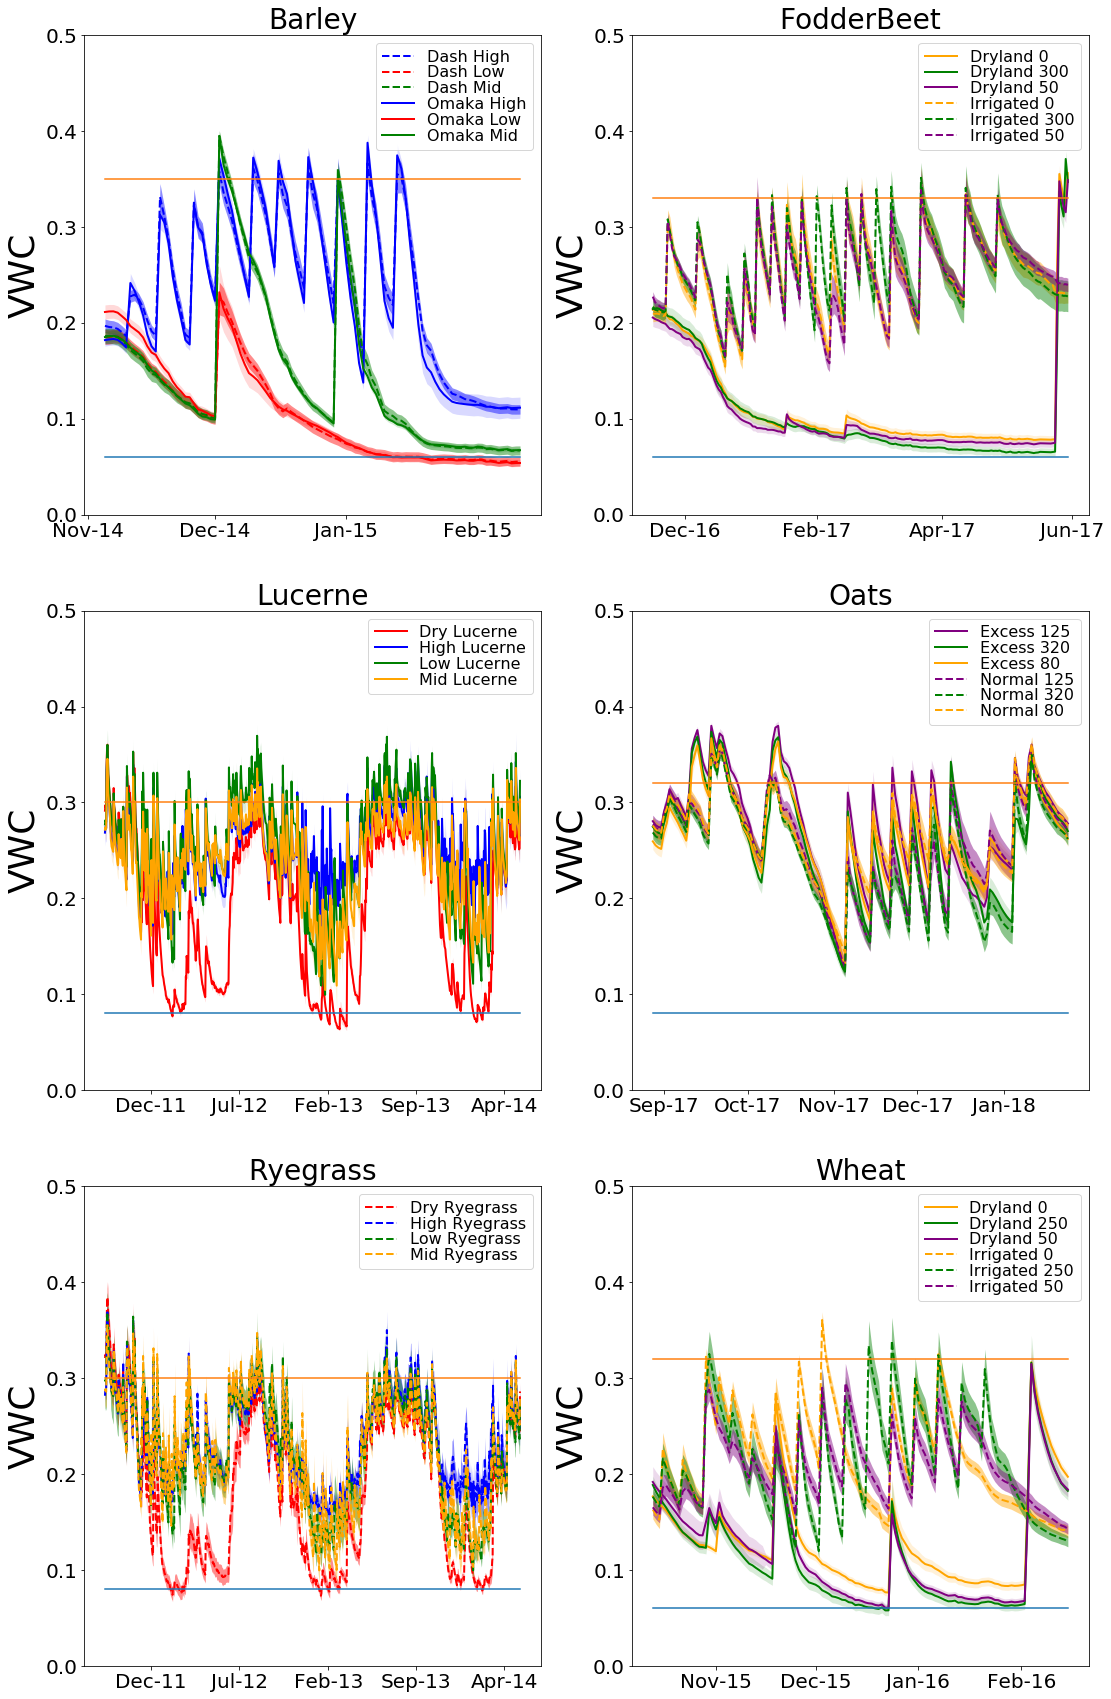

In [45]:
Data = TopVWC
Graph = plt.figure(figsize=(18,30))
Crops = Data.columns.get_level_values(0).drop_duplicates().values
Crops.sort()
pos = 1
for C in Crops:
    GP = globals()[C+'GPs']
    ax = Graph.add_subplot(3,2,pos)
    GraphData = Data.loc[:,C].dropna(how='all')
    GH.AddIndexedPlotWithSEM(GraphData,ax,GP,2)
    plt.plot([GraphData.index.min(),GraphData.index.max()],[Params.loc[C,'LL'],Params.loc[C,'LL']],'-')
    plt.plot([GraphData.index.min(),GraphData.index.max()],[Params.loc[C,'FC'],Params.loc[C,'FC']],'-')
    plt.ylabel('VWC', fontsize=36);
    plt.ylim(0,0.5)
    plt.tick_params(labelsize=20)
    plt.title(C, fontsize=28)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=int(np.ceil(Data.loc[:,C].dropna(how='all').index.size/30/5))))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    GH.AddLegend(1,16,'')
    pos+=1

## Calculate relative water content of profiles

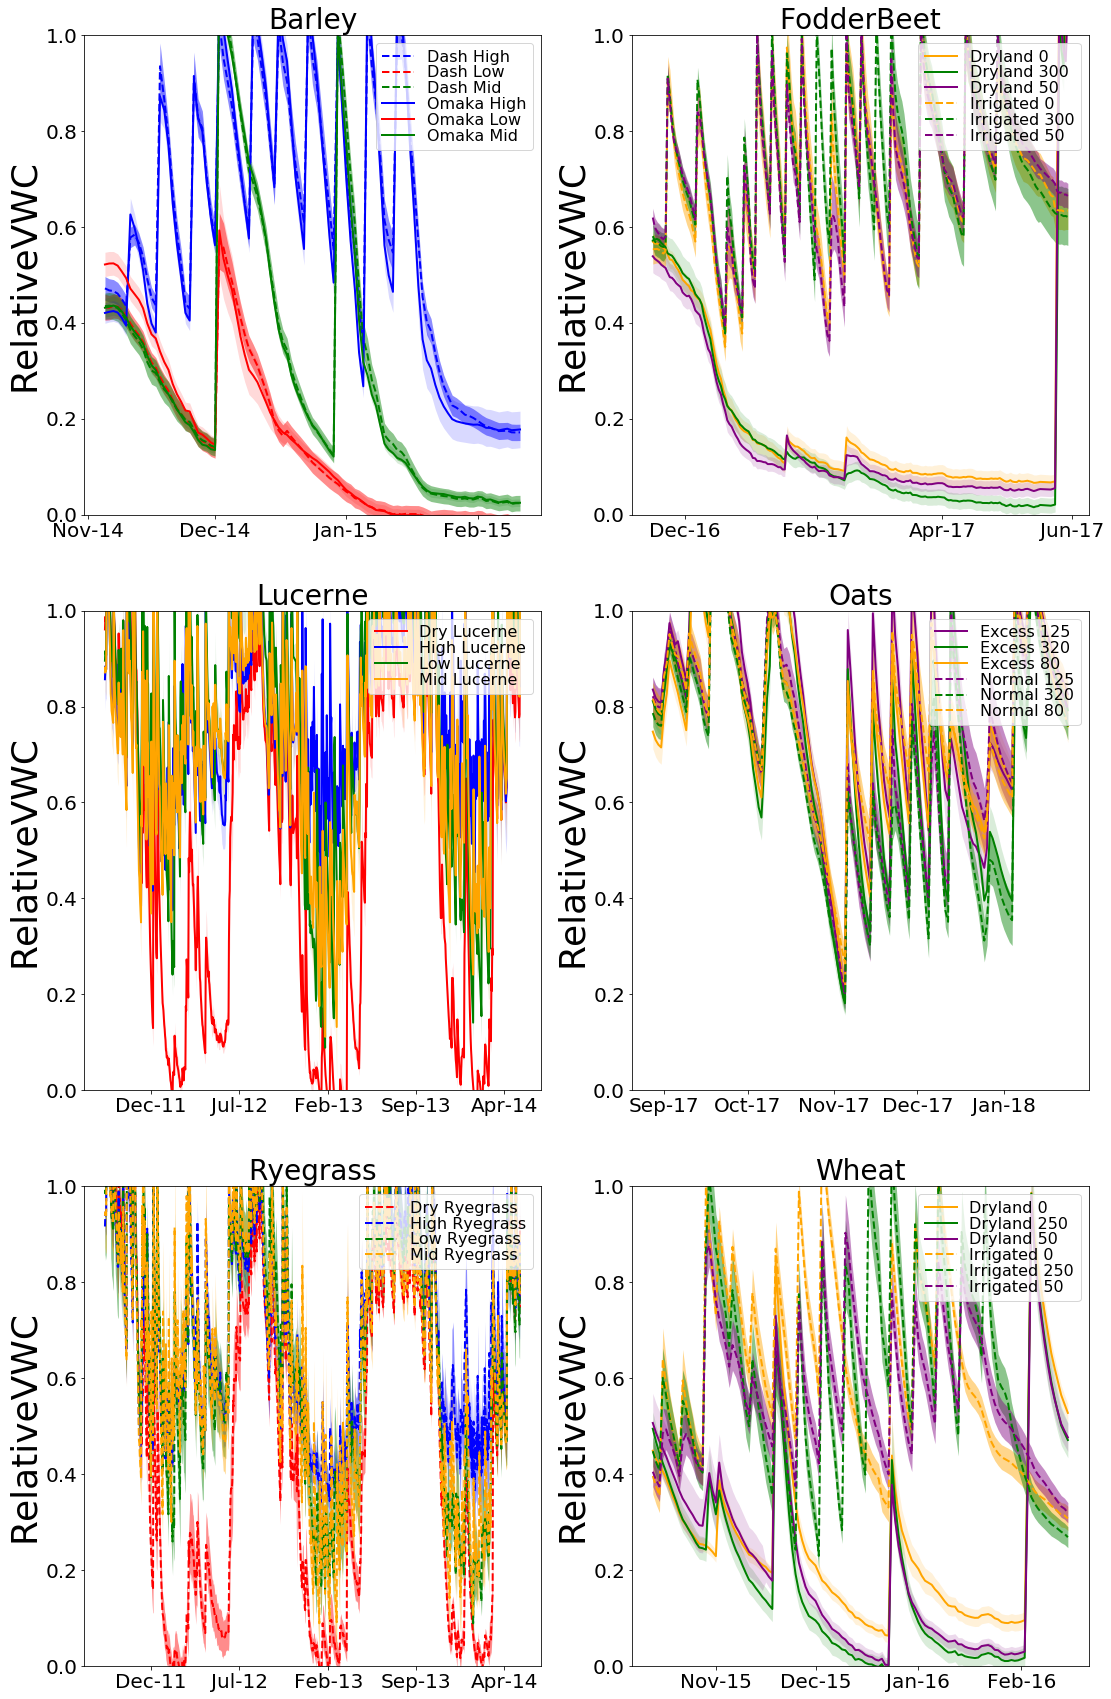

In [46]:
RelativeVWC = TopVWC.copy()
for col in RelativeVWC.columns:
    Crop = col[0]
    LL = Params.loc[Crop,'LL']
    FC = Params.loc[Crop,'FC']
    RelativeVWC.loc[:,col] = RelativeVWC.loc[:,col].subtract(LL).divide(FC-LL)
MakeTimeSeriesGraphs(RelativeVWC,'RelativeVWC',0,1)
    

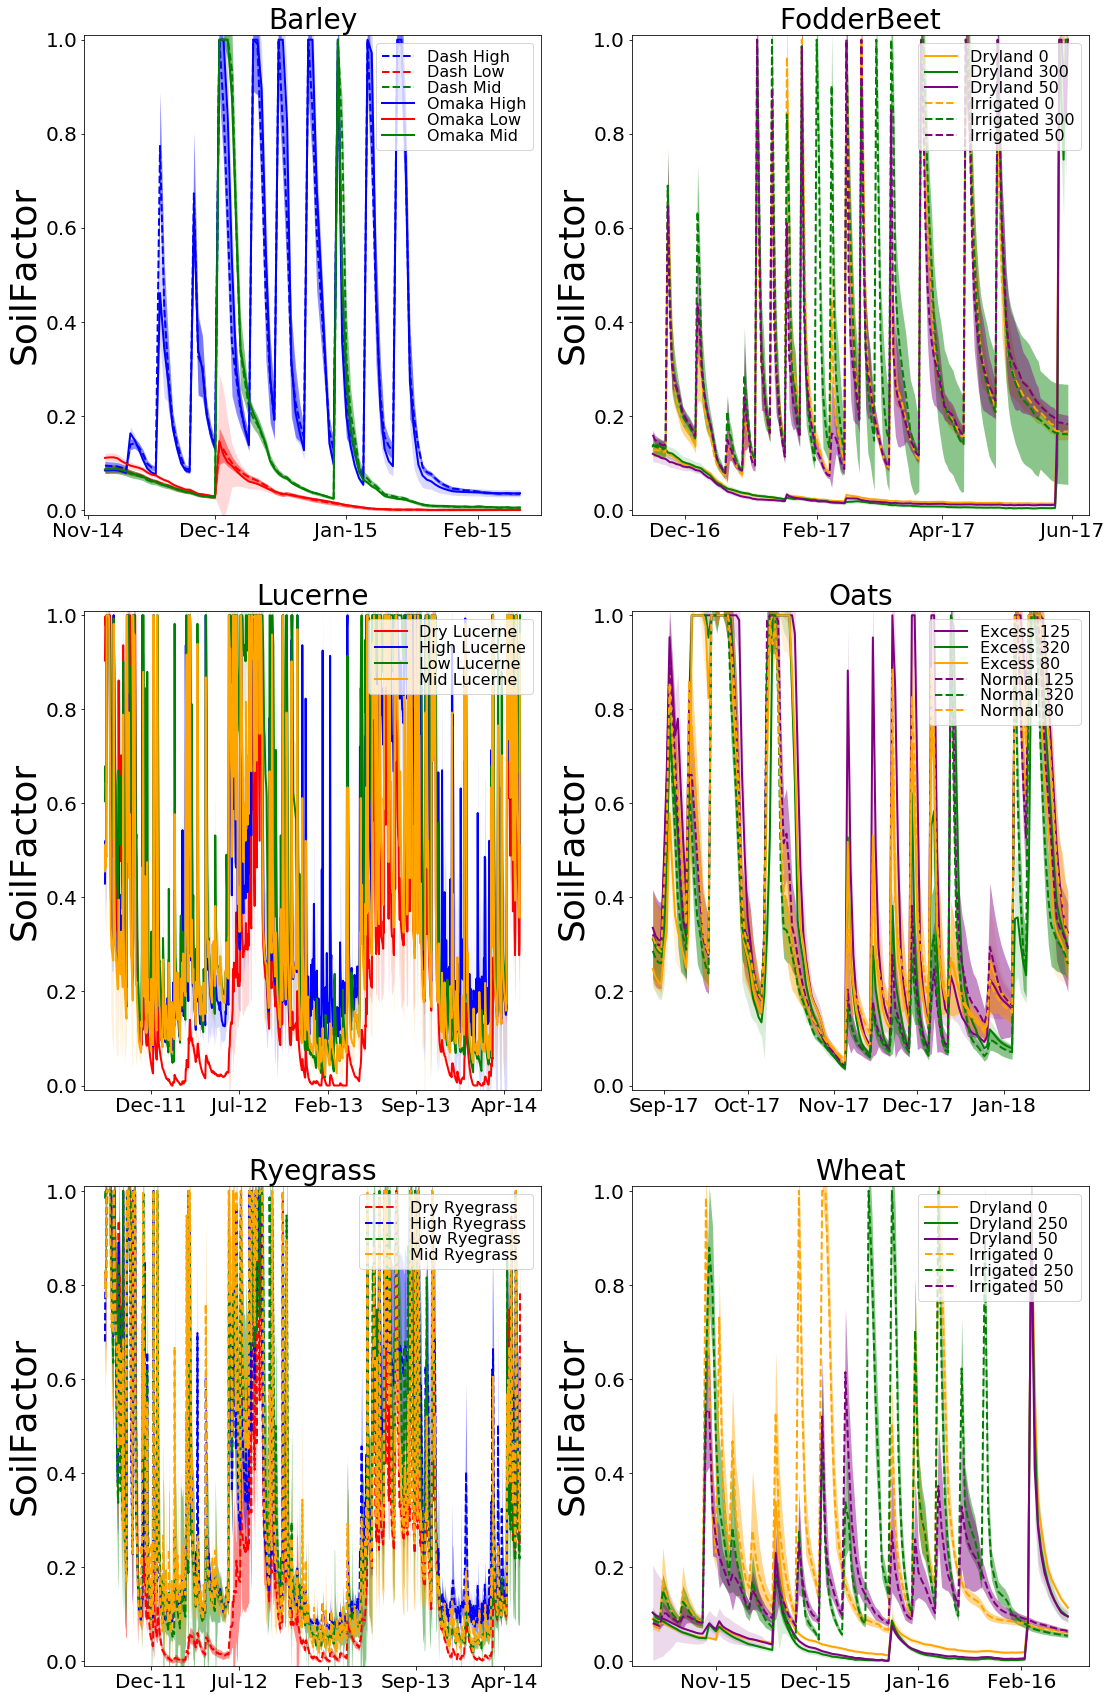

In [47]:
SoilFactor = RelativeVWC.copy()
for col in range(SoilFactor.columns.size):
    SoilFactor.iloc[:,col] = [np.interp(SoilFactor.iloc[x,col],[0,0.5,0.7,0.85,0.98,1.0],[0,0.1,0.2,0.35,1.00,1.0]) for x in range(SoilFactor.index.size)]
MakeTimeSeriesGraphs(SoilFactor,'SoilFactor',-.01,1.01)
    

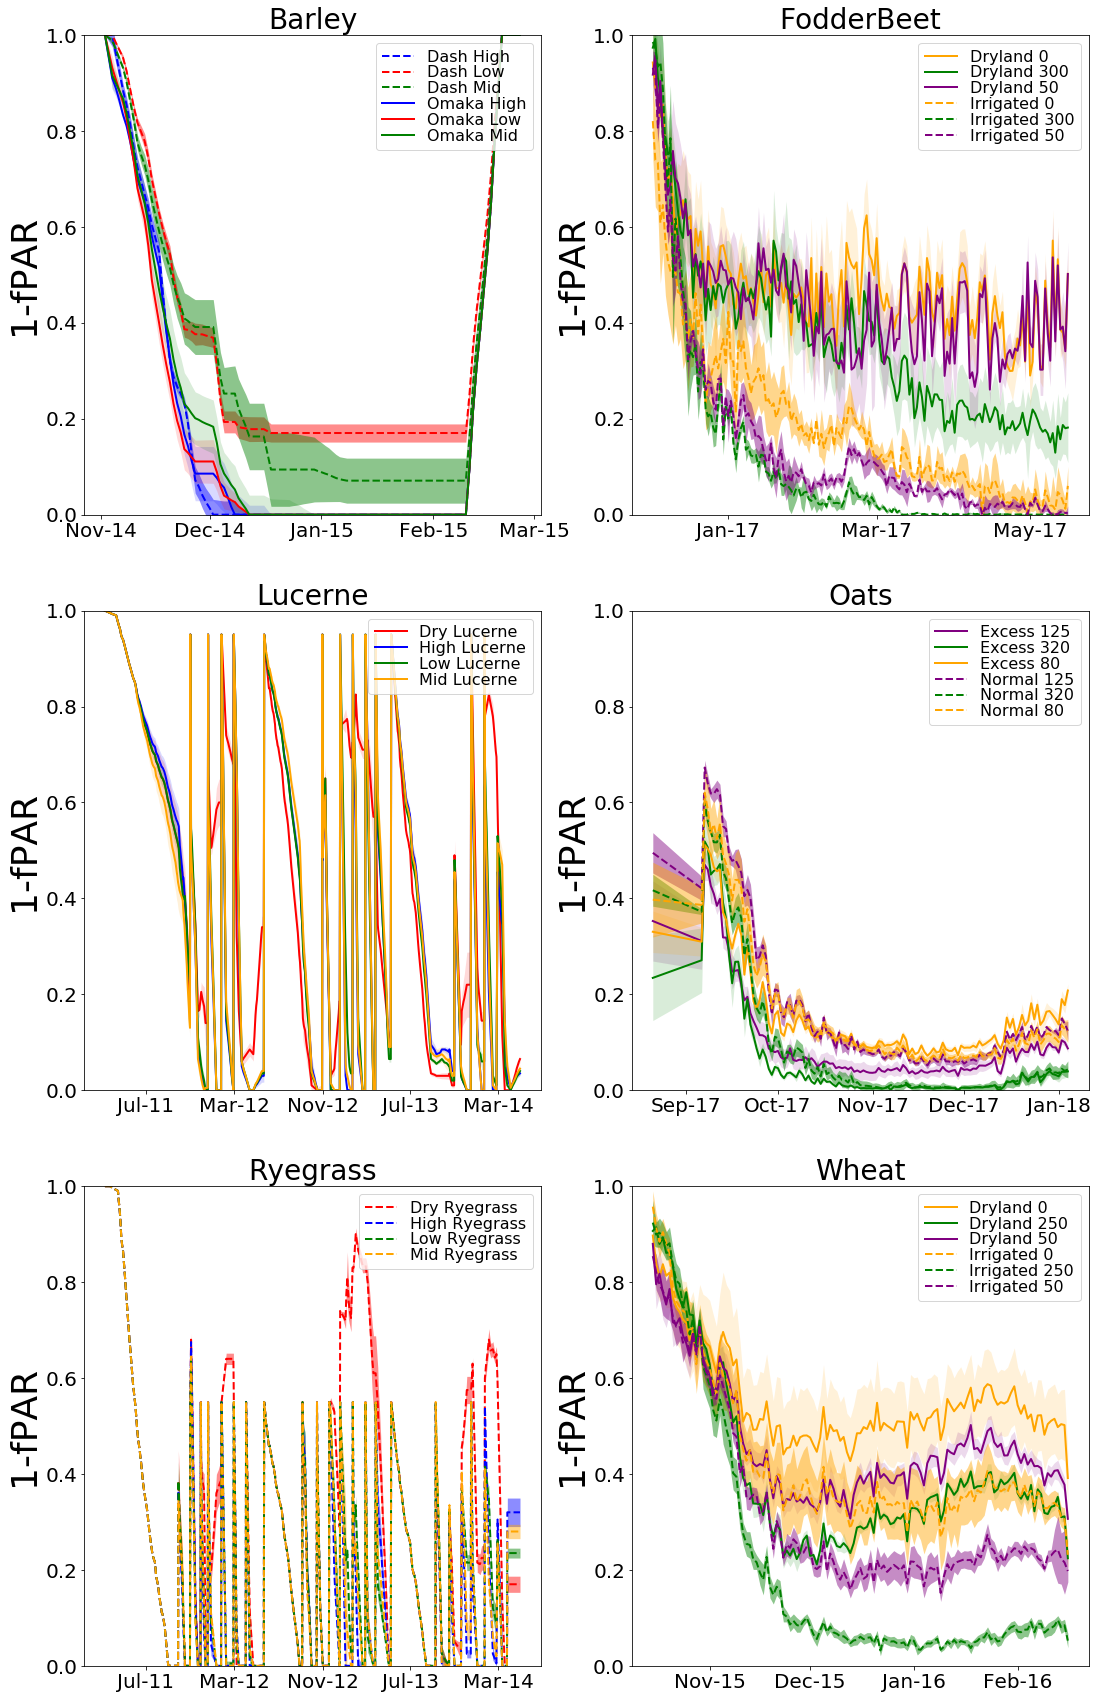

In [48]:
Transmittance = 1-fPAR
MakeTimeSeriesGraphs(Transmittance,'1-fPAR',0,1)

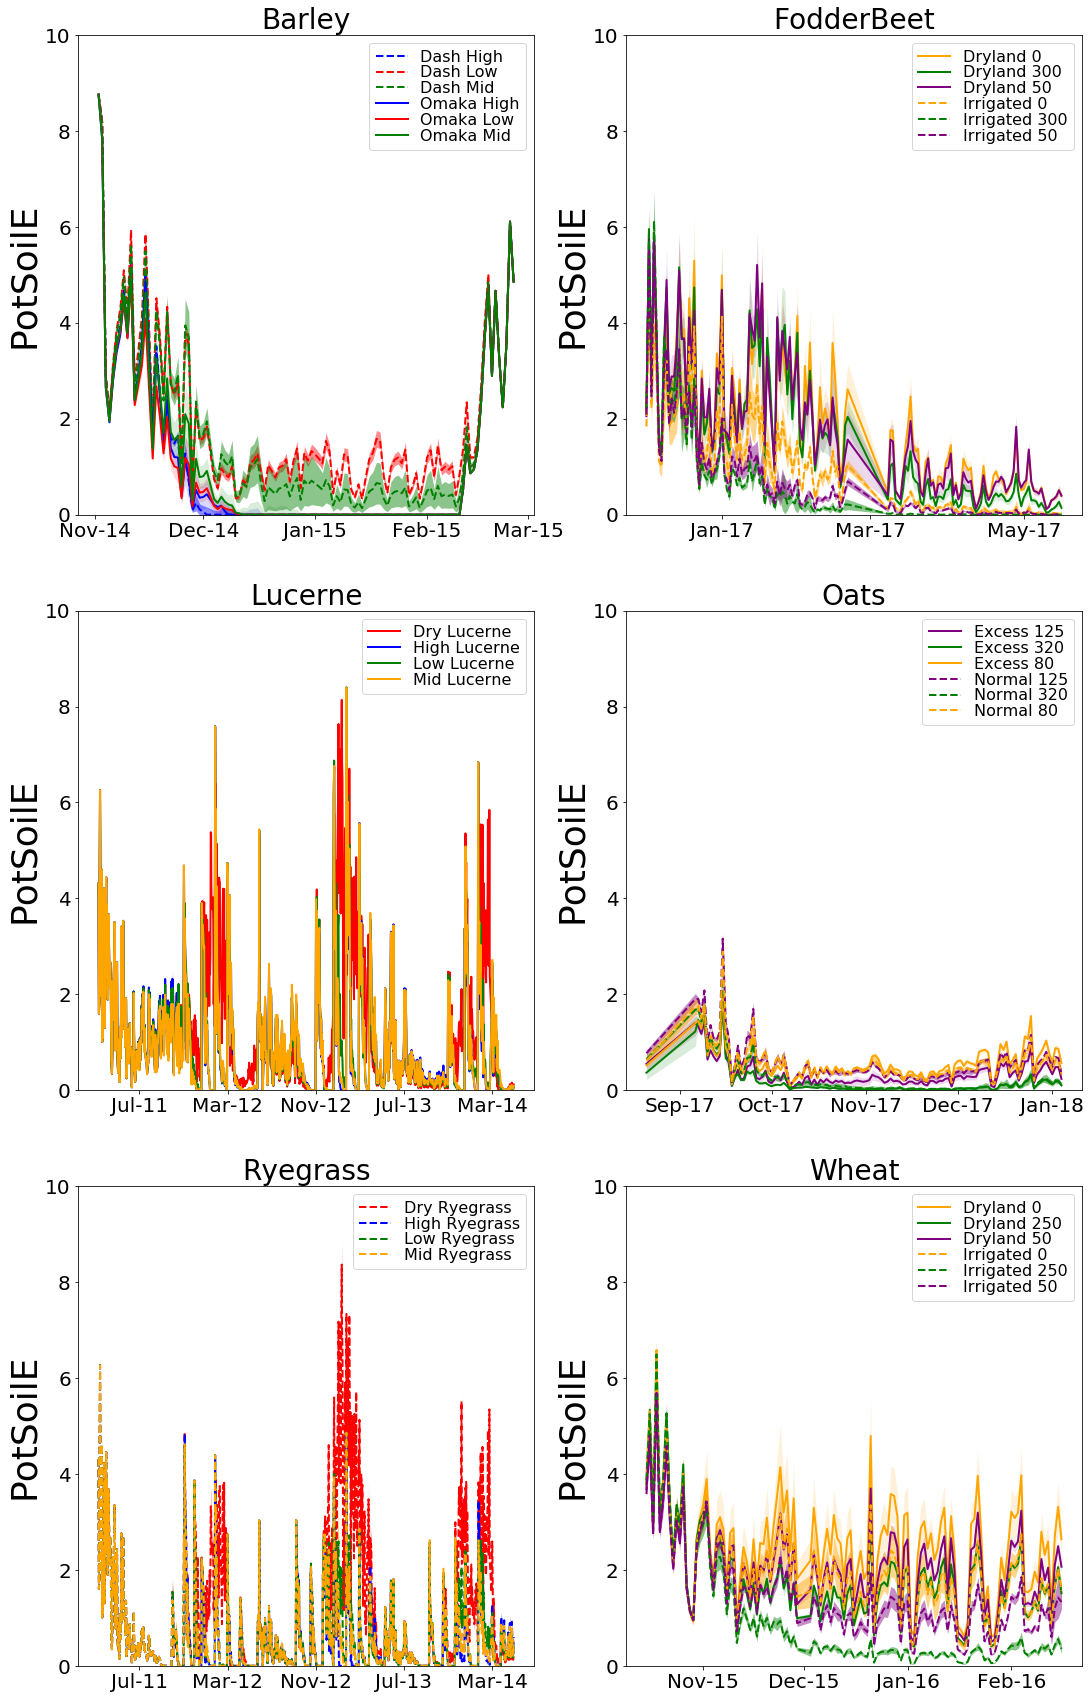

In [49]:
PotSoilEvap = Transmittance.copy()
for col in PotSoilEvap:
    PotSoilEvap.loc[:,col] = PotSoilEvap.loc[:,col].multiply(DailyMet.loc[PotSoilEvap.loc[:,col].index,'PET'].values) 
MakeTimeSeriesGraphs(PotSoilEvap,'PotSoilE',0,10)

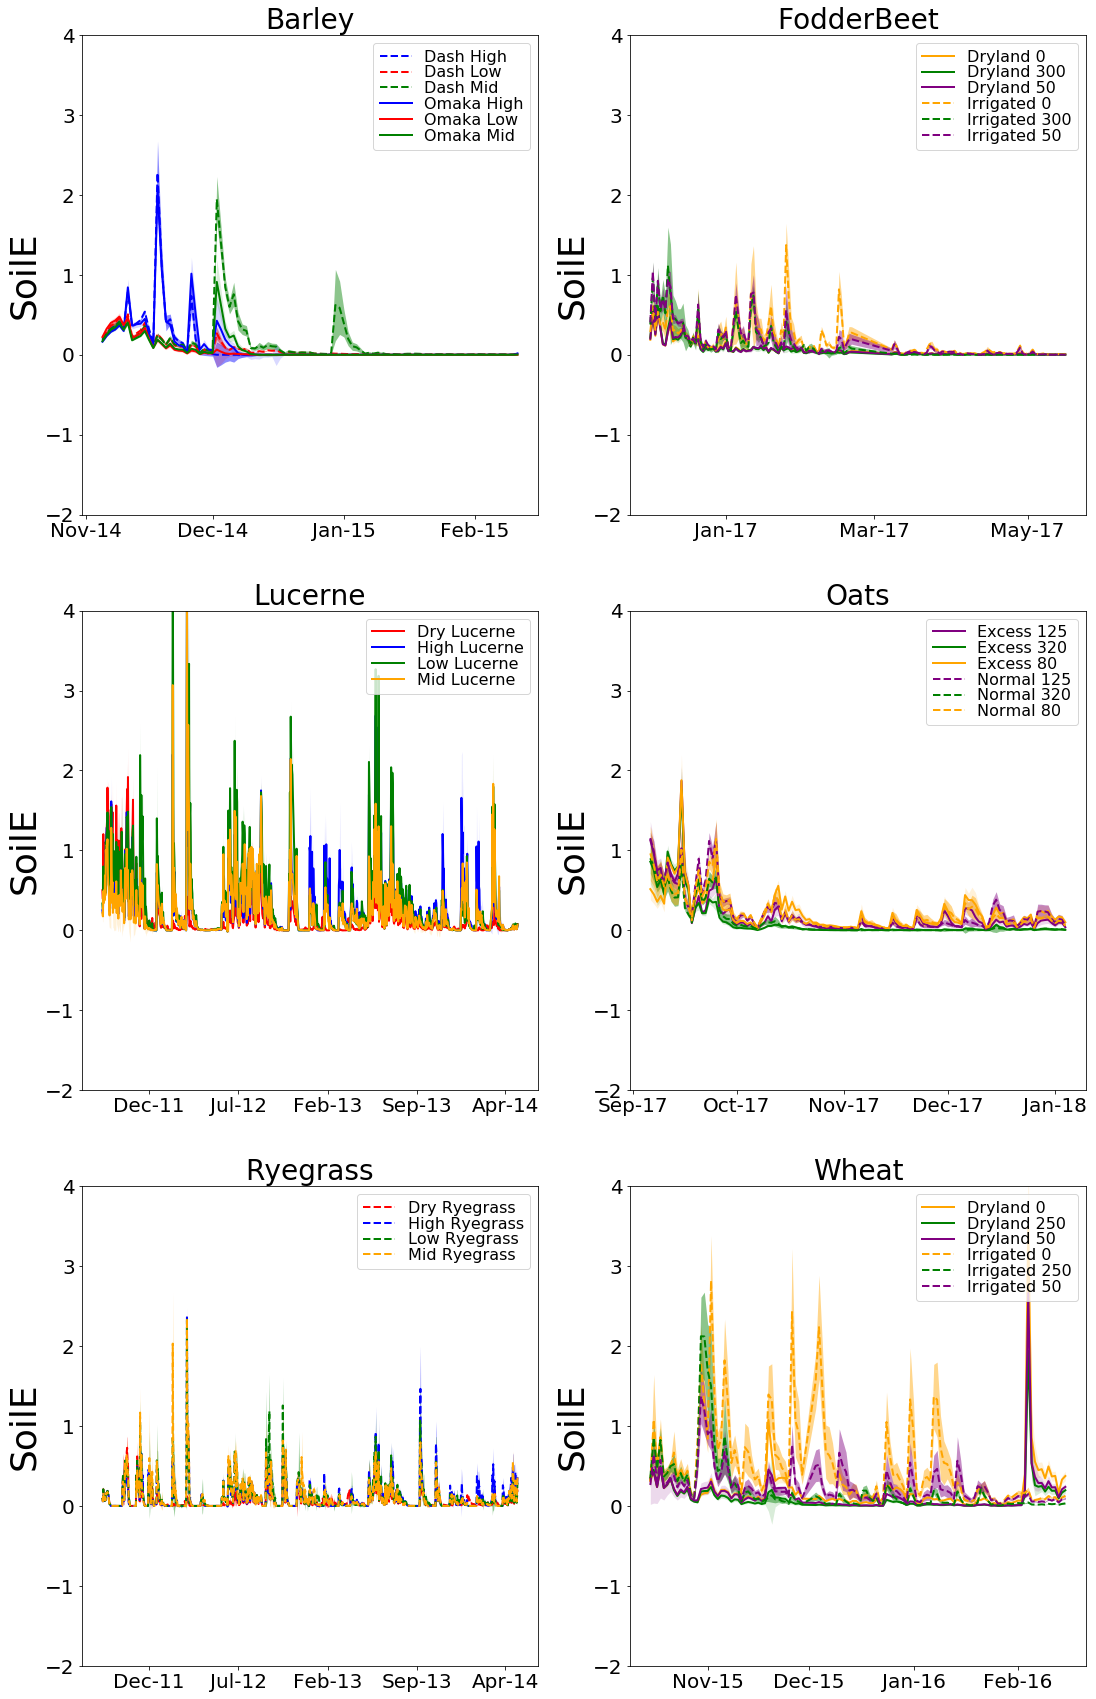

In [50]:
SoilEvap = pd.DataFrame(index = PotSoilEvap.index, columns = PotSoilEvap.columns)
MeanSoilFactor = SoilFactor.groupby(level=['Crop','Irrigation','Nitrogen','Block'],axis=1).mean()
for col in SoilEvap.columns:
       SoilEvap.loc[:,col] = PotSoilEvap.loc[:,col] * MeanSoilFactor.loc[:,col]                                                 
MakeTimeSeriesGraphs(SoilEvap,'SoilE',-2,4)

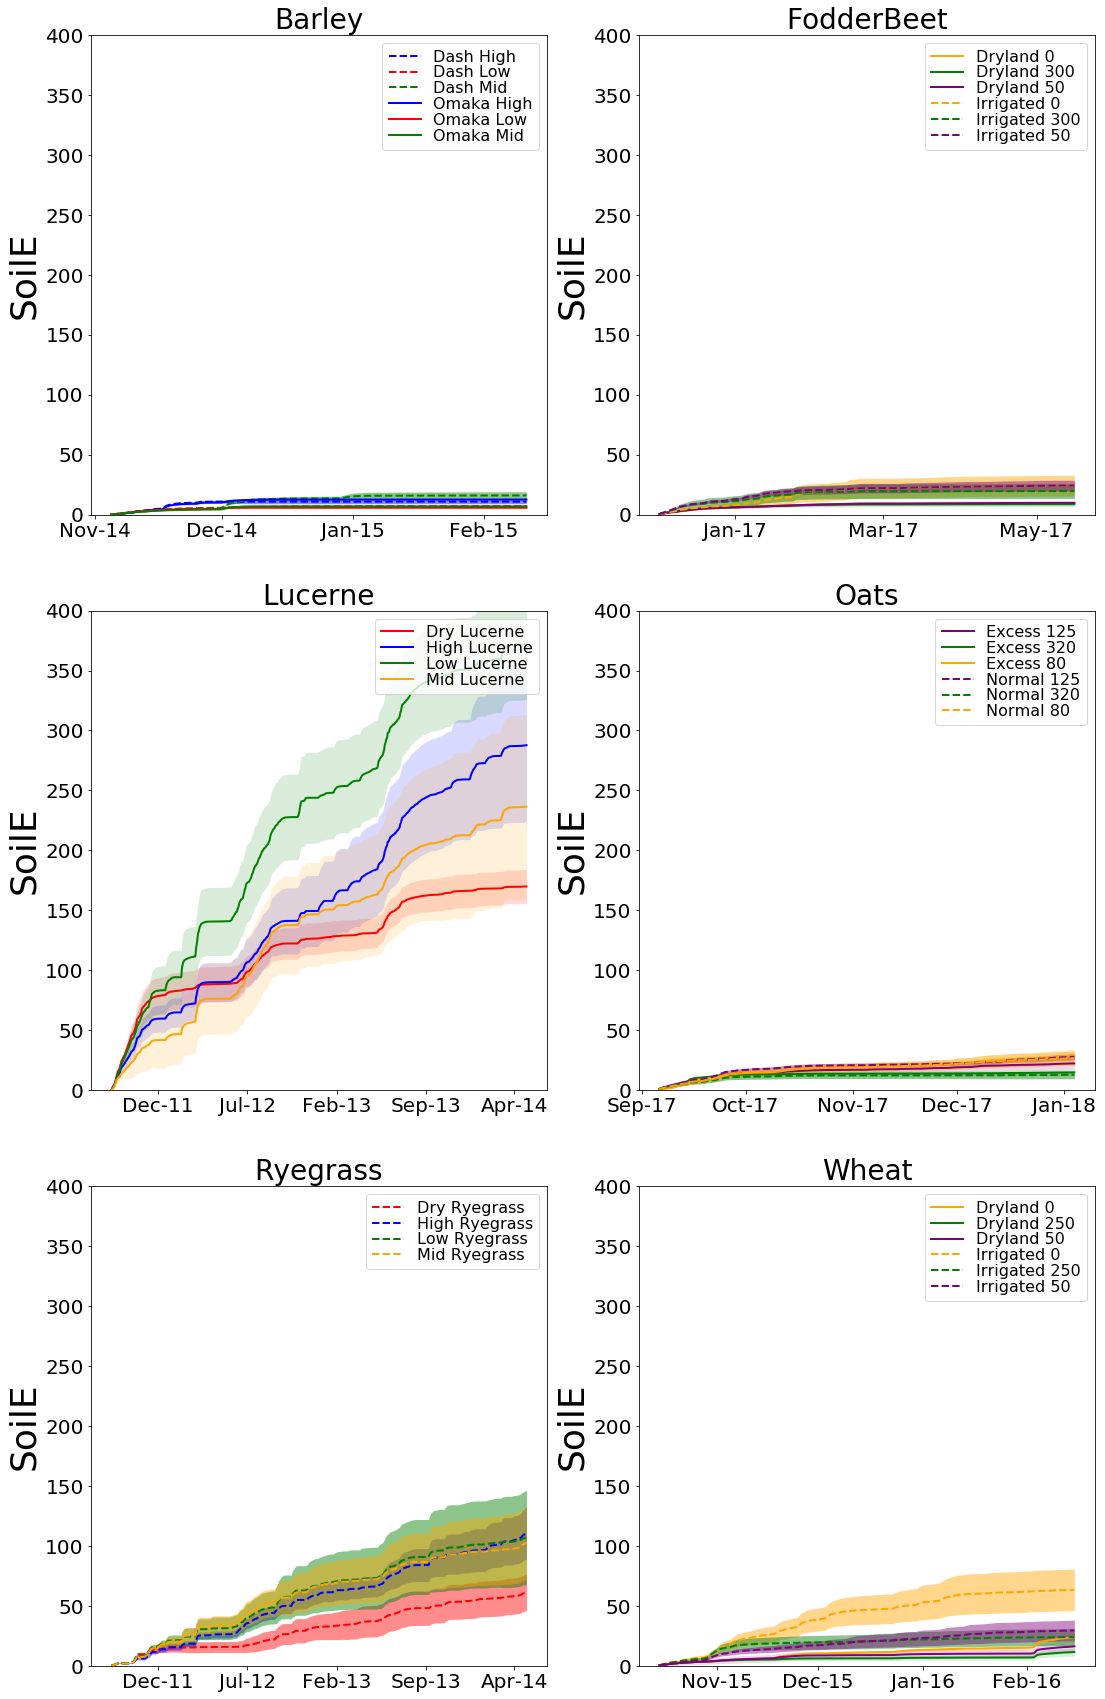

In [51]:
MakeTimeSeriesGraphs(SoilEvap.cumsum(axis=0),'SoilE',0,400)

In [52]:
SoilEvap.to_pickle('.\DataFrames\Evaporation.pkl')

In [53]:
SoilEvap

Crop       Barley                                     ...     Wheat          \
Irrigation   Dash                                     ... Irrigated           
Nitrogen     High             Low             Mid     ...         0     250   
Block           1   2   3   4   1   2   3   4   1   2 ...         3   4   1   
2011-03-10    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-11    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-12    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-13    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-14    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-15    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-16    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-17    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-18    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-19    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-20    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-21    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-22    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-23    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-24    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-25    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-26    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-27    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-28    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-29    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-30    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-03-31    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-04-01    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-04-02    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-04-03    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-04-04    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-04-05    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-04-06    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-04-07    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2011-04-08    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  .. ...       ...  ..  ..   
2017-12-06    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-07    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-08    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-09    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-10    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-11    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-12    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-13    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-14    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-15    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-16    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-17    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-18    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-19    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-20    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...       NaN NaN NaN   
2017-12-21    NaN NaN NaN NaN NaN NaN NaN NaN NaN 